<a href="https://colab.research.google.com/github/MikJak75/ResearchCopies/blob/main/Copy_of_nr_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import Python related required packages
import io
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Dimension of the graphs
in_d1 = 2
in_d2 = 96
#Number of epochs
num_epochs = 120

In [4]:
#!git clone https://github.com/MikJak75/ResearchCopies.git

In [5]:
#import sys
#sys.path.insert(0,'/content/drive/My Drive/ColabNotebooks')
##sys.path.insert(0,'/content/my_functions')
##%load my_functions.ipynb
#import my_functions.ipynb



In [6]:
#Downloand numpy arrays for neutron reflectivity curves and parameters used to generate 
#them
# !gdown "https://drive.google.com/uc?id=1--SS7PoObNsKwwN8Hg__ZBRvPCqqEBpA"
# !gdown "https://drive.google.com/uc?id=1SmWTmLlvg-cEyzXIlt8ik286pQ4nE86G"
!gdown "https://drive.google.com/uc?id=1-6ALZXrYmhZk2FrBZEGobjghaNXzVYGM"
!gdown "https://drive.google.com/uc?id=1wSwycTpnzYWdbzCUficcG9mC_ij1prb8"

Downloading...
From: https://drive.google.com/uc?id=1-6ALZXrYmhZk2FrBZEGobjghaNXzVYGM
To: /content/sld_fp49.npy
100% 9.13M/9.13M [00:00<00:00, 17.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wSwycTpnzYWdbzCUficcG9mC_ij1prb8
To: /content/params_fp49.npy
100% 143k/143k [00:00<00:00, 101MB/s]


In [7]:
#Stored those numpy arrays
sld_arr = np.load('sld_fp49.npy')
params_arr = np.load('params_fp49.npy')

In [8]:
sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype

((5942, 2, 96), (5942, 3), dtype('float64'), dtype('float64'))

In [9]:
#Split data functioin
def split_input_arrays(in_data,label_data,size_split):

    xtr, xjunk, ytr, yjunk = train_test_split(in_data,label_data,train_size=size_split)
    xv, xte, yv, yte = train_test_split(xjunk,yjunk, test_size=0.5)
    print('xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape')
    print(xtr.shape, ytr.shape, xv.shape, yv.shape, xte.shape, yte.shape)
    return xtr, ytr, xv, yv, xte, yte

In [10]:
#Create dataset and dataloaders from splitted arrays
def get_dataloaders_fromsplitarrays(xtr,ytr,xv,yv,xte,yte,batch_size):

    tr_set = torch.utils.data.TensorDataset(torch.from_numpy(xtr).float(), torch.from_numpy(ytr).float())
    tr_load = torch.utils.data.DataLoader(tr_set, batch_size=batch_size, shuffle=True)

    va_set = torch.utils.data.TensorDataset(torch.from_numpy(xv).float(), torch.from_numpy(yv).float())
    va_load = torch.utils.data.DataLoader(va_set, batch_size=batch_size, shuffle=True)

    te_set = torch.utils.data.TensorDataset(torch.from_numpy(xte).float(), torch.from_numpy(yte).float())
    te_load = torch.utils.data.DataLoader(te_set, batch_size=batch_size, shuffle=True)

    return tr_set, va_set, te_set, tr_load, va_load, te_load 

In [11]:
xtrain, ytrain, xval, yval, xtest, ytest = \
split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 96) (4753, 3) (594, 2, 96) (594, 3) (595, 2, 96) (595, 3)


In [12]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [42]:
class Encoder(nn.Module):
    
    def __init__(self,encoded_space_dim,dim1,dim2):
        super().__init__()
        self.layers = []


        self.encoder = nn.Sequential(
        nn.Linear(dim1 * dim2, 100),
        nn.ReLU(True),
        nn.Linear(100,100),
        nn.ReLU(True),
        nn.Linear(100,encoded_space_dim))
        
    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self,encoded_space_dim,dim1,dim2):
        super().__init__()

        self.decoder = nn.Sequential(
        nn.Linear(encoded_space_dim, 100),
        nn.ReLU(True),
        nn.Linear(100, 100),
        nn.ReLU(True),
        nn.Linear(100, dim1 * dim2))
        
    def forward(self, x):
        x = self.decoder(x)
        return x

In [14]:
loss_fn = torch.nn.MSELoss()
lr= 0.001
torch.manual_seed(0)

encoder = Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2)
decoder = Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Move encoder to device
encoder.to(device)

#Move decoder to device
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=192, bias=True)
  )
)

In [15]:
#encoder.parameters().__next__()[1][20]
#encoder[0].weight
#print(encoder)
#print(list(encoder.parameters()))
#print( list(encoder.parameters())[0].)
#encoder.state_dict()['encoder.0.weight']

tensor([[-0.0005,  0.0387, -0.0594,  ...,  0.0391,  0.0573,  0.0494],
        [-0.0509,  0.0032, -0.0509,  ..., -0.0185,  0.0318,  0.0643],
        [ 0.0239,  0.0721,  0.0374,  ..., -0.0479, -0.0054,  0.0597],
        ...,
        [ 0.0012,  0.0229,  0.0216,  ..., -0.0288,  0.0021,  0.0400],
        [-0.0284,  0.0421,  0.0260,  ...,  0.0578, -0.0065,  0.0280],
        [ 0.0306, -0.0464,  0.0602,  ..., -0.0346,  0.0115, -0.0543]],
       device='cuda:0')

In [16]:
#Move encoder to device
#encoder.to(device)

In [17]:
#Move decoder to device
#decoder.to(device)

In [18]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    train_loss = []
    for data,label in dataloader: 
        img = data
        img = img.view(img.size(0), -1).to(device)  
        label = label.to(device)
        latent = encoder(img)
        decoded_img = decoder(latent)
        loss = loss_fn(decoded_img, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [19]:
### Valid function
def valid_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): 
        list_decoded_img = []
        list_img = []
        for  data, label in dataloader:
            img = data
            img = img.view(img.size(0), -1).to(device) 
            label = label.to(device)
            latent = encoder(img)
            decoded_img = decoder(latent)
            list_decoded_img.append(decoded_img.cpu())
            list_img.append(img.cpu())
        list_decoded_img = torch.cat(list_decoded_img)
        list_img = torch.cat(list_img) 
        val_loss = loss_fn(list_decoded_img, list_img)
    return val_loss.data

In [20]:
def plot_ae_outputs(encoder,decoder,dataset,device,n=10):
    plt.figure(figsize=(26,5.5))
    for i in range(10):
      ax = plt.subplot(2,n,i+1)
      img,_ = dataset[i]
      #Notice that below i'm loading an image only, so it needs to be flatten
      #before entering the network
      img = torch.flatten(img).to(device)
      encoder.eval().to(device)
      decoder.eval().to(device)
      with torch.no_grad():
        decoded_img = decoder(encoder(img))
      plt.plot(img.cpu().reshape(2,128).numpy()[0],img.cpu().reshape(2,128).numpy()[1]) 
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n) 
      plt.plot(decoded_img.cpu().reshape(2,128).numpy()[0],decoded_img.cpu().reshape(2,128).numpy()[1]) 
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

In [38]:
# num_epochs = 120
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = valid_epoch(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/120 	 train loss 5.511364361154847e-05 	 val loss 8.201494347304106e-05
EPOCH 2/120 	 train loss 5.061864430899732e-05 	 val loss 5.3435513109434396e-05
EPOCH 3/120 	 train loss 6.043397661414929e-05 	 val loss 7.046697282930836e-05
EPOCH 4/120 	 train loss 5.585059625445865e-05 	 val loss 5.951678758719936e-05
EPOCH 5/120 	 train loss 7.505047688027844e-05 	 val loss 9.16765711735934e-05
EPOCH 6/120 	 train loss 4.911533687845804e-05 	 val loss 5.026516373618506e-05
EPOCH 7/120 	 train loss 4.495302346185781e-05 	 val loss 4.332272874307819e-05
EPOCH 8/120 	 train loss 5.557000622502528e-05 	 val loss 4.980369340046309e-05
EPOCH 9/120 	 train loss 4.915729005006142e-05 	 val loss 4.8499197873752564e-05
EPOCH 10/120 	 train loss 6.500136805698276e-05 	 val loss 7.08275256329216e-05
EPOCH 11/120 	 train loss 5.3170460887486115e-05 	 val loss 5.827739732922055e-05
EPOCH 12/120 	 train loss 5.147160482010804e-05 	 val loss 5.1838815124938264e-05
EPOCH 13/120 	 train loss 6.3617721

In [39]:
encoder.state_dict()['encoder.0.weight']

tensor([[-1.4090e-39, -8.4743e-22, -2.2907e-20,  ...,  6.7786e-24,
          6.7800e-24,  6.7792e-24],
        [ 1.5396e-39,  1.7772e-04,  2.9214e-04,  ..., -2.7111e-03,
         -2.7111e-03, -2.7111e-03],
        [ 7.3537e-40, -1.3704e-28, -8.7737e-29,  ..., -1.9845e-28,
         -1.9845e-28, -1.9845e-28],
        ...,
        [ 1.8363e-39,  5.0686e-04,  9.7425e-04,  ...,  8.5048e-03,
          8.5048e-03,  8.5048e-03],
        [ 6.8099e-40,  2.0923e-04,  4.7151e-04,  ..., -3.7286e-03,
         -3.7286e-03, -3.7286e-03],
        [-3.2115e-40,  1.8013e-04,  3.8144e-04,  ...,  9.0083e-04,
          9.0083e-04,  9.0083e-04]], device='cuda:0')

In [34]:
#save network state

torch.save(encoder.state_dict(), "./enc_net.py")

In [40]:
encoder.load_state_dict(torch.load("./enc_net.py"))

<All keys matched successfully>

In [41]:
encoder.state_dict()['encoder.0.weight']

tensor([[-1.4089e-39, -3.3158e-13, -8.2548e-13,  ...,  5.7568e-14,
          5.7766e-14,  5.7664e-14],
        [ 1.5059e-39,  1.6268e-04,  3.2630e-04,  ...,  6.2622e-03,
          6.2622e-03,  6.2622e-03],
        [ 7.2931e-40, -9.2275e-06, -1.7992e-05,  ..., -1.2392e-11,
         -1.1977e-11, -1.2386e-11],
        ...,
        [ 1.8359e-39,  4.4544e-04,  8.6418e-04,  ...,  3.4810e-03,
          3.4810e-03,  3.4811e-03],
        [ 6.7319e-40,  2.4790e-04,  4.8968e-04,  ...,  6.0071e-04,
          6.0071e-04,  6.0071e-04],
        [-3.1678e-40,  2.3076e-04,  4.5157e-04,  ...,  1.0632e-03,
          1.0632e-03,  1.0632e-03]], device='cuda:0')

In [22]:
#print(diz_loss['train_loss'][-1])
#print(diz_loss['val_loss'][-1])
#print(encoder)
#print(encoder.parameters())
#for param in encoder.parameters():
#  print(param[0])
print( encoder.parameters().__next__()[1][20])
print(encoder.parameters().__next__()[1][20])

tensor(0.0034, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<SelectBackward0>)


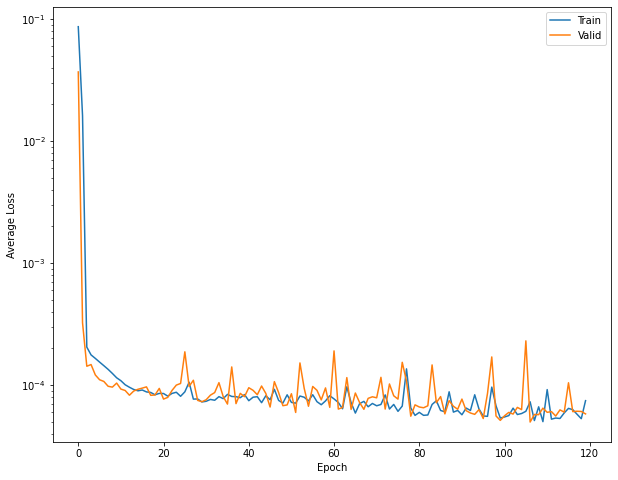

In [23]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

For image 0, the loss = 0.00012285247794352472
For image 1, the loss = 5.545138265006244e-05
For image 2, the loss = 1.6892608982743695e-05
For image 3, the loss = 7.748559437459335e-05
For image 4, the loss = 3.4659165976336226e-05
For image 5, the loss = 3.422907320782542e-05
For image 6, the loss = 3.35490949510131e-05
For image 7, the loss = 3.7642639654222876e-05
For image 8, the loss = 0.00010947544797090814
For image 9, the loss = 2.9293047191458754e-05


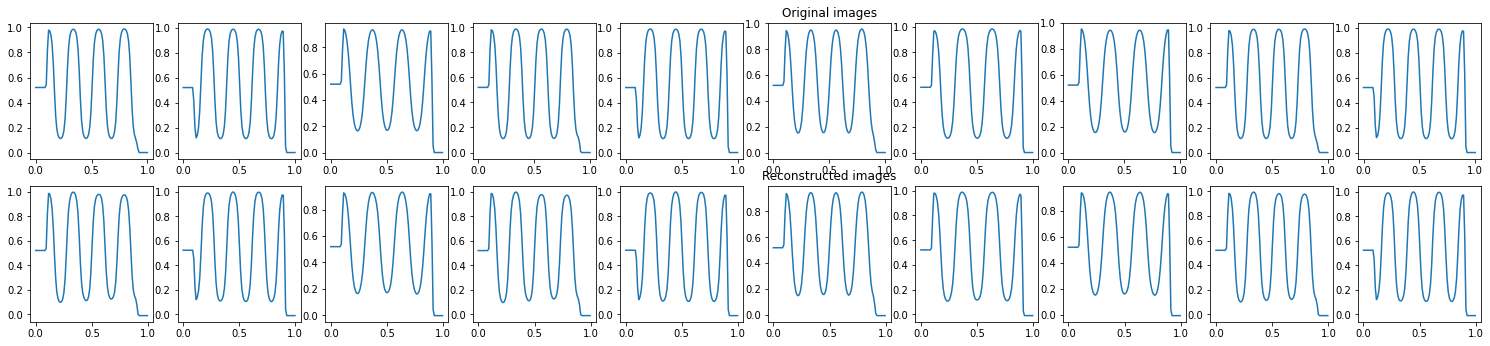

In [24]:
#Seeing how the model performs for the test unseen data. For this we choose 10 figures
#running through model.eval() and compute the loss plus we look at them visually

#Similar to plot_ae_outputs, except that this is one used to see the loss for 
#data in the test_loader. It also prints the loss for each
def plot_test_outputs(encoder,decoder,dataset,device,n=10):
    plt.figure(figsize=(26,5.5))
    for i in range(10):
      ax = plt.subplot(2,n,i+1)
      img,_ = dataset[i]
      #Notice that below i'm loading an image only, so it needs to be flatten
      #before entering the network
      img = torch.flatten(img).to(device)
      encoder.eval().to(device)
      decoder.eval().to(device)
      with torch.no_grad():
         decoded_img  = decoder(encoder(img))
         loss = loss_fn(decoded_img,img)
         print('For image {}, the loss = {}'.format(i,loss.data))
      plt.plot(img.cpu().reshape(in_d1,in_d2).numpy()[0],img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n) 
      plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  


plot_test_outputs(encoder,decoder,test_dataset,device,n=10)

In [25]:
#Running the autoencoder on the train data. The goal here is to obtain the
#latent variables so they can be plot and also for training a MLP

def get_latent_variables(encoder, decoder, device, dataloader):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): 
        # Define the lists to store the original images, the recreated ones,
        # the latent variables and the corresponding labels
        list_img = []
        list_decoded_img = []
        list_latent = []
        list_labels = []

        for  data, label in dataloader:
            img = data
            img = img.view(img.size(0), -1).to(device) 
            # Encode and Decode data
            latent = encoder(img)
            decoded_img = decoder(latent)
            # Append the network output and the original image to the lists
            list_img.append(img.cpu())
            list_decoded_img.append(decoded_img.cpu())
            list_latent.append(latent.cpu())
            list_labels.append(label.cpu())
# Convert list into a torch.tensor
        t_img = torch.cat(list_img)
        t_decoded_img = torch.cat(list_decoded_img)
        t_latent = torch.cat(list_latent) 
        t_labels = torch.cat(list_labels)
    return t_img, t_decoded_img, t_latent, t_labels

tensor([-2.1936, -0.7967,  4.0853])
tensor([2.3738, 2.8225, 1.0623])


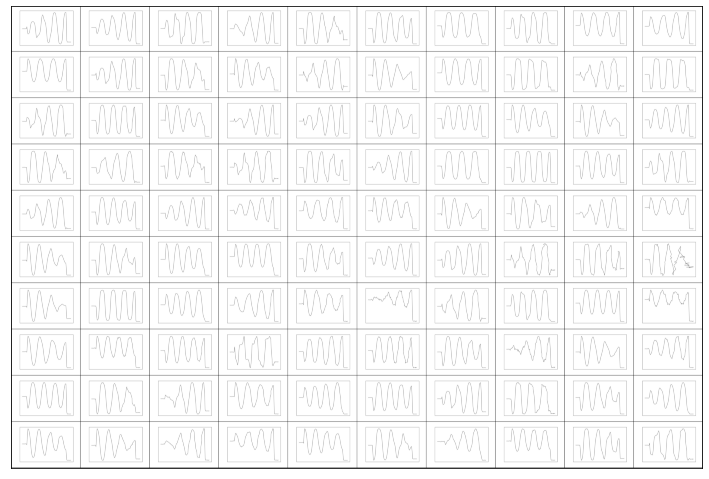

In [26]:
#Interpolating in the latent space

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [27]:
nlabel = params_arr.shape[1]
nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  print(label_index)

label0
label1
label2


In [28]:
encoded_samples = []
for sample in tqdm(train_dataset):
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
      encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

100%|██████████| 4753/4753 [00:01<00:00, 3227.63it/s]


,l1,l2,l3,label0,label1,label2
0,-5.189554,-0.879657,2.758553,0.0974,0.0612,0.13124
1,-5.189554,-0.879657,2.758553,0.0974,0.0612,0.13124
2,-5.189554,-0.879657,2.758553,0.0974,0.0612,0.13124
3,-2.025930,-5.163136,3.562410,0.128,0.578,-0.01027
4,-2.025930,-5.163136,3.562410,0.128,0.578,-0.01027
...,...,...,...,...,...,...
14254,-1.969584,-5.179961,3.592630,0.167,0.523,-0.37441
14255,-1.969584,-5.179961,3.592630,0.167,0.523,-0.37441
14256,-2.380943,3.084151,4.534121,0.106,-0.356,0.44594
14257,-2.380943,3.084151,4.534121,0.106,-0.356,0.44594


In [29]:
#Creating dataloaders for the MLP. This includes train, valid and test
#Saving them on disk too

img, out_img, train_latent_var, train_labels_var = get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 192]) torch.Size([4753, 192]) torch.Size([4753, 3]) torch.Size([4753, 3])
torch.Size([594, 192]) torch.Size([594, 192]) torch.Size([594, 3]) torch.Size([594, 3])
torch.Size([595, 192]) torch.Size([595, 192]) torch.Size([595, 3]) torch.Size([595, 3])


In [30]:
#Saving data into drive

from google.colab import drive
drive.mount('/content/drive')

torch.save(train_latent_var,'train_latent_var.pt')
torch.save(train_latent_var,'train_labels_var.pt')

torch.save(valid_latent_var,'valid_latent_var.pt')
torch.save(valid_latent_var,'valid_labels_var.pt')

torch.save(test_latent_var,'test_latent_var.pt')
torch.save(test_latent_var,'test_labels_var.pt')

!mv train_latent_var.pt /content/drive/MyDrive/neutron_reflectivity/
!mv train_labels_var.pt /content/drive/MyDrive/neutron_reflectivity/
!mv valid_latent_var.pt /content/drive/MyDrive/neutron_reflectivity/
!mv valid_labels_var.pt /content/drive/MyDrive/neutron_reflectivity/
!mv test_latent_var.pt /content/drive/MyDrive/neutron_reflectivity/
!mv test_labels_var.pt /content/drive/MyDrive/neutron_reflectivity/

torch.save(mlp_train_loader,'mlp_train_loader.pth')
torch.save(mlp_valid_loader,'mlp_valid_loader.pth')
torch.save(mlp_test_loader,'mlp_test_loader.pth')

!mv mlp_train_loader.pth /content/drive/MyDrive/neutron_reflectivity/
!mv mlp_valid_loader.pth /content/drive/MyDrive/neutron_reflectivity/
!mv mlp_test_loader.pth /content/drive/MyDrive/neutron_reflectivity/

#Saving also the pandas dataframe for the encoded sample

#Having issues with the way a saved .csv and loaded one look like. 
# df_encoded_samples.to_csv('encoded.csv', sep ='\t')
# !mv encoded.csv /content/drive/MyDrive/neutron_reflectivity/

#Using pickle instead.
df_encoded_samples.to_pickle('df_encoded_samples.pkl')
!mv df_encoded_samples.pkl /content/drive/MyDrive/neutron_reflectivity/


Mounted at /content/drive
mv: cannot create regular file '/content/drive/MyDrive/neutron_reflectivity/': Not a directory
mv: cannot create regular file '/content/drive/MyDrive/neutron_reflectivity/': Not a directory
mv: cannot create regular file '/content/drive/MyDrive/neutron_reflectivity/': Not a directory
mv: cannot create regular file '/content/drive/MyDrive/neutron_reflectivity/': Not a directory
mv: cannot create regular file '/content/drive/MyDrive/neutron_reflectivity/': Not a directory
mv: cannot create regular file '/content/drive/MyDrive/neutron_reflectivity/': Not a directory
mv: cannot create regular file '/content/drive/MyDrive/neutron_reflectivity/': Not a directory
mv: cannot create regular file '/content/drive/MyDrive/neutron_reflectivity/': Not a directory
mv: cannot create regular file '/content/drive/MyDrive/neutron_reflectivity/': Not a directory
mv: cannot create regular file '/content/drive/MyDrive/neutron_reflectivity/': Not a directory


In [31]:
!pip install ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
#from ipynb.fs.full.my_functions import factorial


In [33]:
#!git clone https://raw.githubusercontent.com/MikJak75/ResearchCopies/main/Copy_of_nr_v7.ipyn
#
##%load function.py
##
##SomeFunction()
#
#%load my_functions.ipynb
##
##SomeFunction()